In [19]:
!apt-get install cuda=10.2.89-1
!pip install pykeops[full]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
cuda is already the newest version (10.2.89-1).
0 upgraded, 0 newly installed, 0 to remove and 28 not upgraded.


In [20]:
!git clone https://github.com/jeanfeydy/monaco.git
import os.path
import sys
sys.path.append('monaco')
sys.setrecursionlimit(10000)

fatal: destination path 'monaco' already exists and is not an empty directory.


In [21]:
import numpy as np
import torch
from matplotlib import pyplot as plt

plt.rcParams.update({"figure.max_open_warning": 0})

use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor


In [22]:
import pykeops
pykeops.clean_pykeops()          # just in case old build files are still present
pykeops.test_torch_bindings() 

Cleaning /root/.cache/pykeops-1.5-cpython-37/...
    - /root/.cache/pykeops-1.5-cpython-37/libKeOpstorch35e943b4e5 has been removed.
    - /root/.cache/pykeops-1.5-cpython-37/libKeOpstorch180bebcc11 has been removed.
    - /root/.cache/pykeops-1.5-cpython-37/libKeOpstorch6d59ee52ba has been removed.
    - /root/.cache/pykeops-1.5-cpython-37/build-6f516b652b has been removed.
    - /root/.cache/pykeops-1.5-cpython-37/build-pybind11_template-libKeOps_template_574e4b20be has been removed.
    - /root/.cache/pykeops-1.5-cpython-37/libKeOpstorchf6033a176e has been removed.
    - /root/.cache/pykeops-1.5-cpython-37/libKeOpstorch8c766e0bd9 has been removed.
    - /root/.cache/pykeops-1.5-cpython-37/libKeOpstorchd9820006d0 has been removed.
    - /root/.cache/pykeops-1.5-cpython-37/keops_hash.log has been removed.
[pyKeOps] Initializing build folder for dtype=float32 and lang=torch in /root/.cache/pykeops-1.5-cpython-37 ... done.
[pyKeOps] Compiling libKeOpstorch180bebcc11 in /root/.cache/pyke

In [23]:
from monaco.euclidean import EuclideanSpace

D = 8
space = EuclideanSpace(dimension=D, dtype=dtype)

In [24]:

from monaco.euclidean import GaussianMixture, UnitPotential
import math

N, M = (100000 if use_cuda else 50), 2
Nlucky = 100 if use_cuda else 2
nruns = 5
niter = 10

test_case = "gaussians"

if test_case == "gaussians":
    # Let's generate a blend of peaky Gaussians, in the unit square:
    m = torch.rand(M, D).type(dtype)  # mean
    s = torch.rand(M).type(dtype)  # deviation
    w = torch.rand(M).type(dtype)  # weights
    
    m[0,:] = (1./(2*math.sqrt(D)))*torch.ones(D).type(dtype)
    m[0,0] = -m[0,0]
    m[1,:] = -(1./(2*math.sqrt(D)))*torch.ones(D).type(dtype)
    m[1,0] = -m[1,0]
    m += 1
    s = math.sqrt(.4/D)*torch.ones(M).type(dtype)
    m /= 2
    s /= 2
    w = torch.ones(M).type(dtype)
    
    w = w / w.sum()  # normalize weights

    distribution = GaussianMixture(space, m, s, w)

In [25]:
from monaco.euclidean import UniformProposal
from monaco.euclidean import GaussianProposal

# exploration = .05
exploration = None
exploration_proposal = UniformProposal(space)
annealing = None

In [26]:
#start = torch.rand(N, D).type(dtype)#uniform start
start = 0.9 + 0.1*torch.rand(N, D).type(dtype) #start in a corner
#start=0.75+0.1*torch.rand(N, D).type(dtype) #start on a minor mode

In [27]:

from monaco.euclidean import BallProposal

proposal = BallProposal(space, scale=[0.1,.016,.024, 0.3],
                        exploration=exploration, exploration_proposal=exploration_proposal)

info = {}

[pyKeOps] Compiling libKeOpstorch8c766e0bd9 in /root/.cache/pykeops-1.5-cpython-37:
       formula: Max_SumShiftExp_Reduction(((((Minus(Sum(Square((Var(0,8,0) - Var(1,8,1))))) / (IntCst(2) * Square(Var(2,1,1)))) + Log(Var(3,1,1))) - Var(4,1,2)) - (IntCst(8) * Log(Var(2,1,1)))),0)
       aliases: Var(0,8,0); Var(1,8,1); Var(2,1,1); Var(3,1,1); Var(4,1,2); 
       dtype  : float32
... 
Done.
[pyKeOps] Compiling libKeOpstorch35e943b4e5 in /root/.cache/pykeops-1.5-cpython-37:
       formula: Sum_Reduction(Sqrt(Sum(Square((Var(0,8,0) - Var(1,8,1))))),0)
       aliases: Var(0,8,0); Var(1,8,1); 
       dtype  : float32
... 
Done.


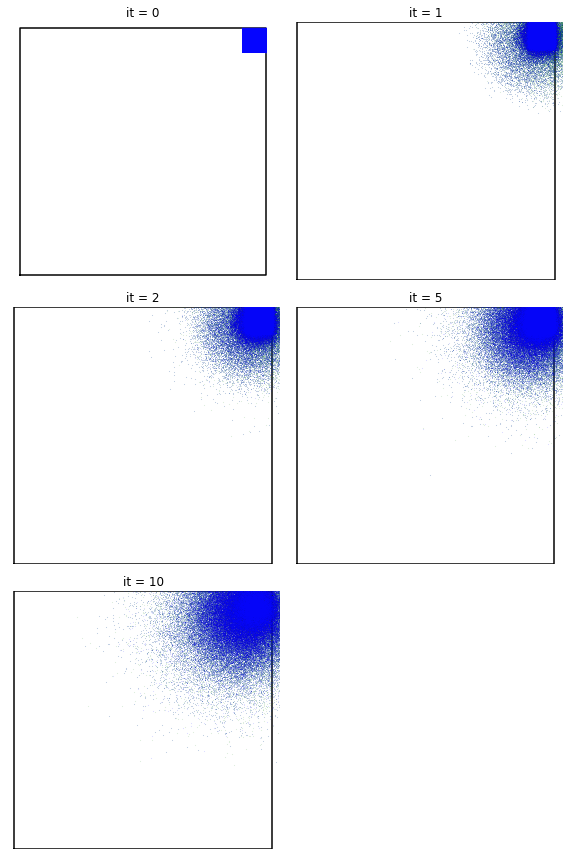

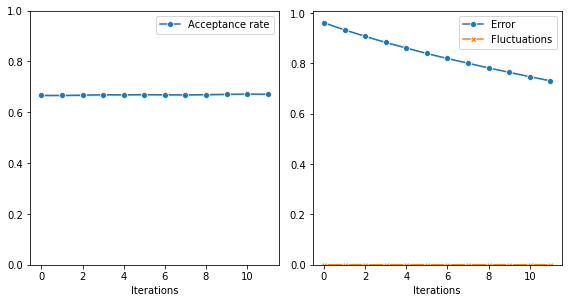

In [28]:




from monaco.samplers import ParallelMetropolisHastings, display_samples

pmh_sampler = ParallelMetropolisHastings(space, start, proposal, annealing=annealing).fit(
    distribution
)
info["PMH"] = display_samples(pmh_sampler, iterations=niter, runs=nruns)


[pyKeOps] Compiling libKeOpstorch22f8c3f23c in /root/.cache/pykeops-1.5-cpython-37:
       formula: Sum_Reduction(((Step((Square(Var(0,4,2)) - Sum(Square((Var(1,8,0) - Var(2,8,1)))))) / (Var(3,1,2) * Pow(Var(0,4,2),8))) / IntCst(100000)),0)
       aliases: Var(0,4,2); Var(1,8,0); Var(2,8,1); Var(3,1,2); 
       dtype  : float32
... 
Done.


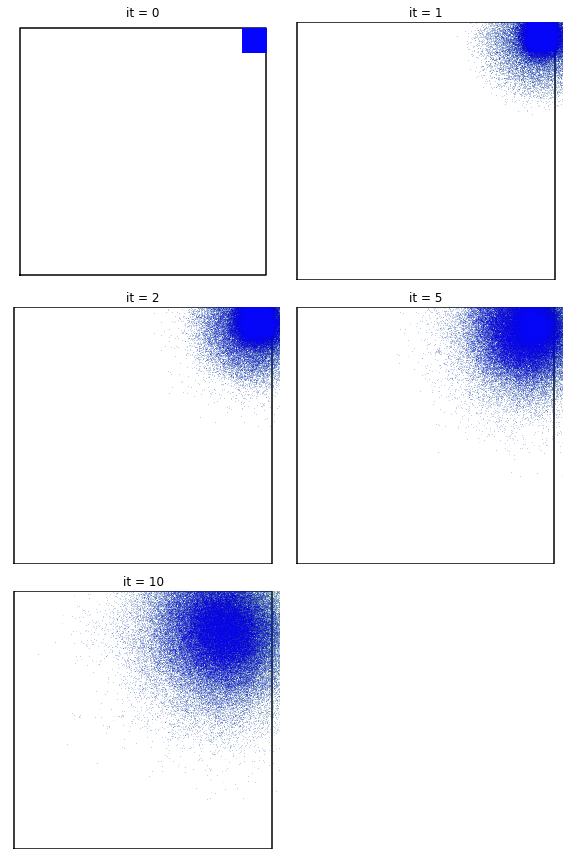

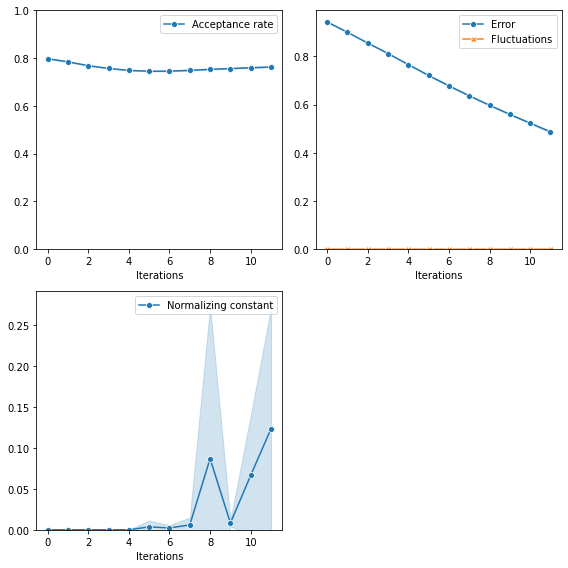

In [29]:


########################################
# Then, the standard Collective Monte Carlo method:


from monaco.samplers import CMC

proposal = BallProposal(space, scale=[0.1,.016,.024, 0.3],
                        exploration=exploration, exploration_proposal=exploration_proposal)

cmc_sampler = CMC(space, start, proposal, annealing=annealing).fit(distribution)
info["CMC"] = display_samples(cmc_sampler, iterations=niter, runs=nruns)



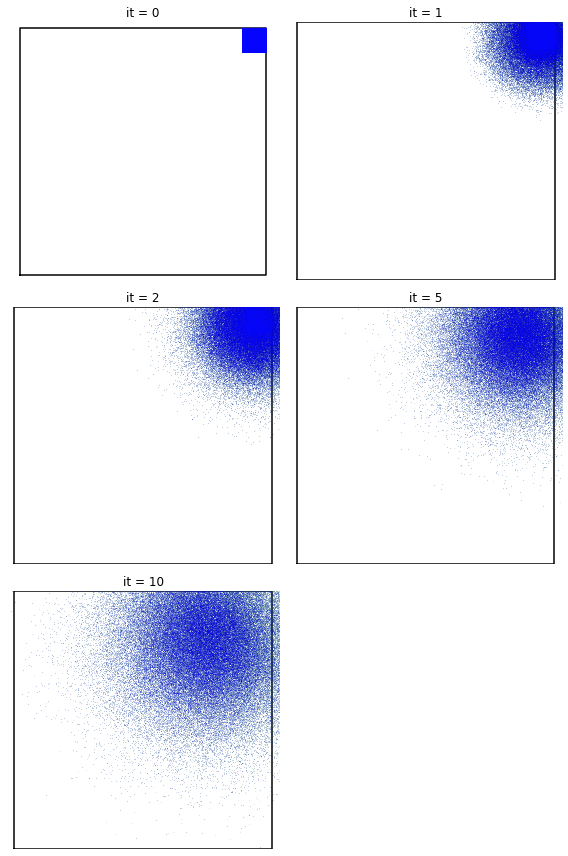

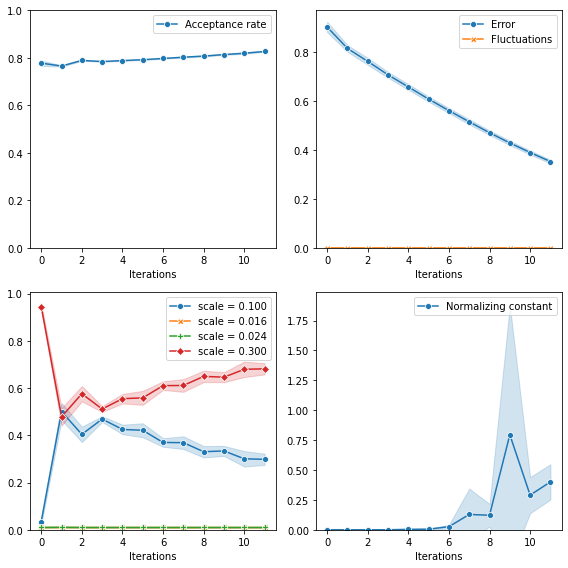

In [30]:

#############################
# Our first algorithm - CMC with adaptive selection of the kernel bandwidth:
from monaco.samplers import MOKA_CMC

multi_scale = [0.1,.016,.024, 0.3]

proposal = BallProposal(space, scale=multi_scale,
                        exploration=exploration, exploration_proposal=exploration_proposal)

moka_sampler = MOKA_CMC(space, start, proposal, annealing=annealing).fit(distribution)
info["MOKA"] = display_samples(moka_sampler, iterations=niter, runs=nruns)

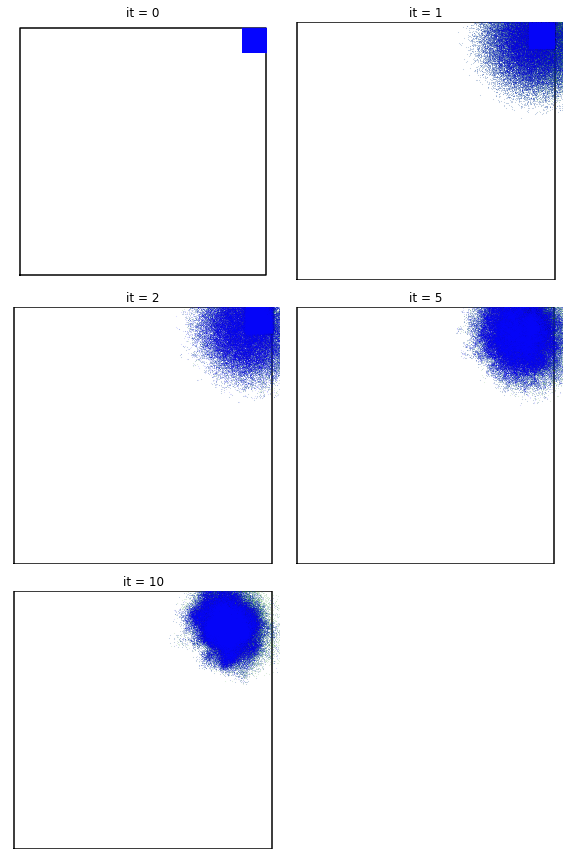

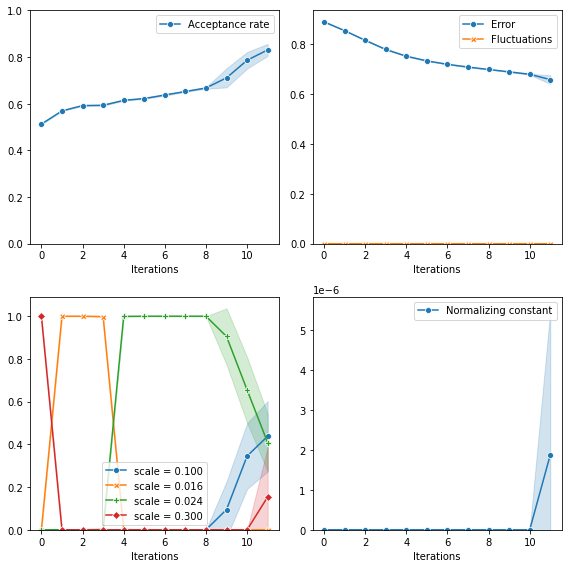

In [31]:


#############################
# With a Markovian selection of the kernel bandwidth:

from monaco.samplers import MOKA_Markov_CMC

proposal = BallProposal(space, scale=[0.1,.016,.024, 0.3],
                        exploration=exploration, exploration_proposal=exploration_proposal)

moka_markov_sampler = MOKA_Markov_CMC(space, start, proposal, annealing=annealing).fit(distribution)
info["MOKA Markov"] = display_samples(moka_markov_sampler, iterations=niter, runs=nruns)




[pyKeOps] Compiling libKeOpstorch6d59ee52ba in /root/.cache/pykeops-1.5-cpython-37:
       formula: Sum_Reduction(((Step((Square(Var(0,4,2)) - Sum(Square((Var(1,8,0) - Var(2,8,1)))))) / (Var(3,1,2) * Pow(Var(0,4,2),8))) * Var(4,1,1)),0)
       aliases: Var(0,4,2); Var(1,8,0); Var(2,8,1); Var(3,1,2); Var(4,1,1); 
       dtype  : float32
... 
Done.


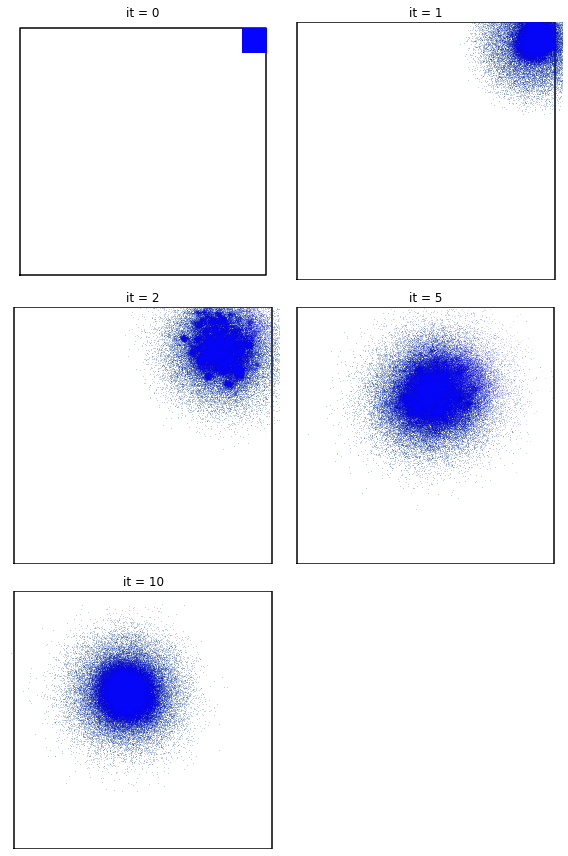

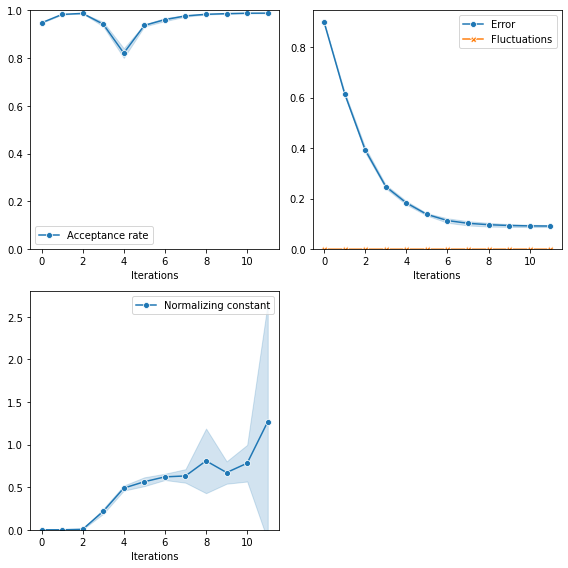

In [32]:

#############################
# Our second algorithm - CMC with Richardson-Lucy deconvolution:

multi_scale = [0.1,.016,.024, 0.3]

from monaco.samplers import KIDS_CMC,display_samples

proposal = BallProposal(space, scale=multi_scale,
                        exploration=exploration, exploration_proposal=exploration_proposal)

kids_sampler = KIDS_CMC(space, start, proposal, annealing=annealing, iterations=niter).fit(
    distribution
)
info["KIDS"] = display_samples(kids_sampler, iterations=niter, runs=nruns)



In [33]:
print(BallProposal.potential)

<function Proposal.potential at 0x7fc99406e9e0>


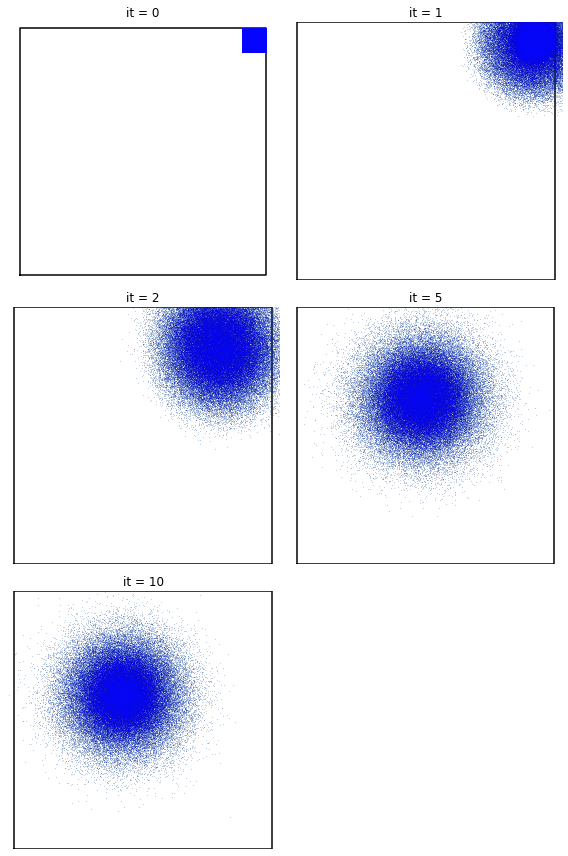

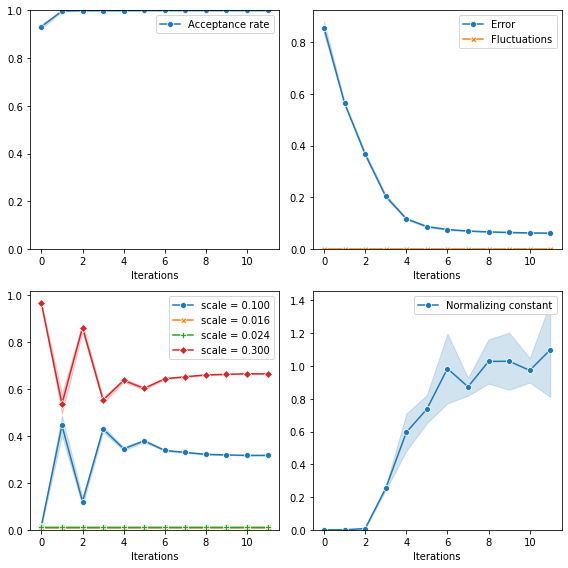

In [34]:

#############################
# Combining bandwith estimation and deconvolution with the Moka-Kids-CMC sampler:


from monaco.samplers import MOKA_KIDS_CMC, display_samples

proposal = BallProposal(space, scale=[0.1,.016,.024, 0.3],
                        exploration=exploration, exploration_proposal=exploration_proposal)


kids_sampler = MOKA_KIDS_CMC(space, start, proposal, annealing=annealing, iterations=niter).fit(
    distribution
)
info["MOKA KIDS"] = display_samples(kids_sampler, iterations=niter, runs=nruns)


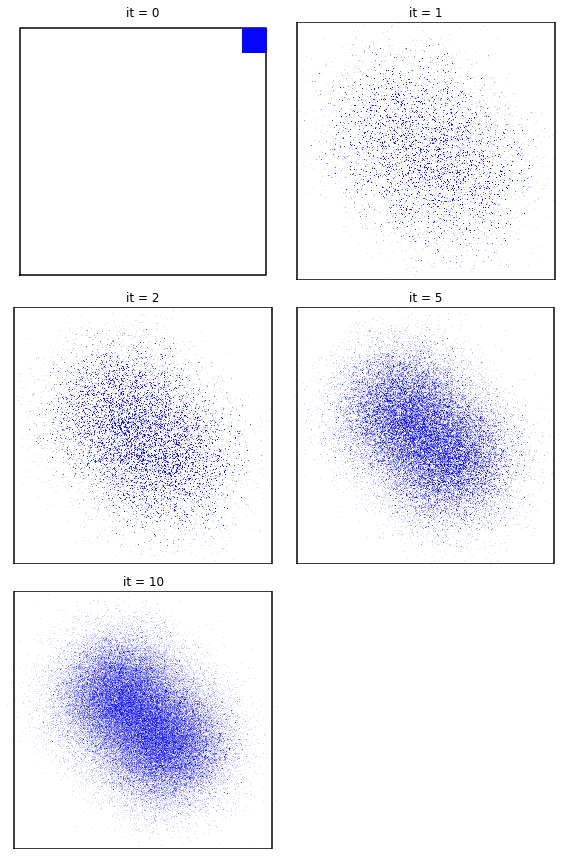

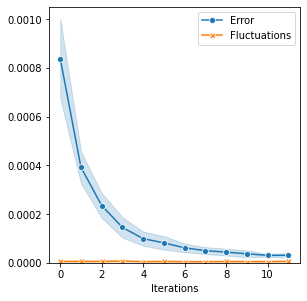

In [35]:


#############################
# Finally, the Non Parametric Adaptive Importance Sampler,
# an efficient non-Markovian method with an extensive
# memory usage:


from monaco.samplers import NPAIS,display_samples

proposal = BallProposal(space, scale=[0.1,.016,.024, 0.3],
                        exploration=exploration, exploration_proposal=exploration_proposal)



class Q_uniform(object):
    def __init__(self):
        None

    def sample(self, n):
        return torch.rand(n, D).type(dtype)

    def potential(self, x):
        return torch.zeros(len(x)).type_as(x)


q0 = Q_uniform()

npais_sampler = NPAIS(space, start, proposal, annealing=5, q0=q0, N=N).fit(distribution)
info["SAIS"] = display_samples(npais_sampler, iterations=niter, runs=nruns)


plt.show()

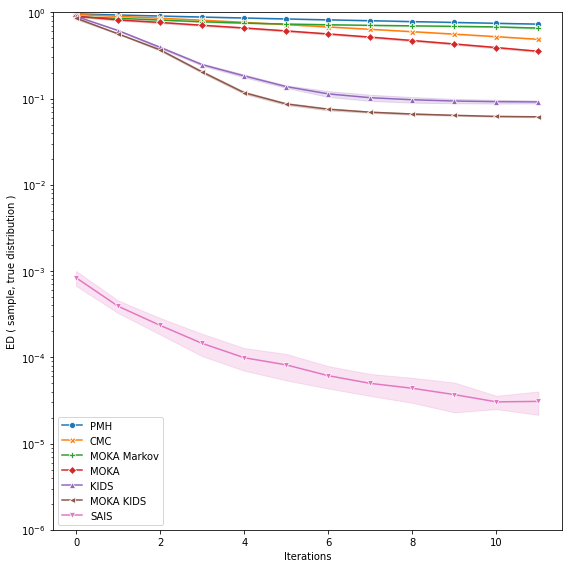

In [36]:
import itertools
import seaborn as sns

iters = info["PMH"]["iteration"]


def display_line(key, marker):
    sns.lineplot(
        x=info[key]["iteration"],
        y=info[key]["error"],
        label=key,
        marker=marker,
        markersize=6,
        ci="sd",
    )


plt.figure(figsize=(8, 8))
markers = itertools.cycle(("o", "X", "P", "D", "^", "<", "v", ">", "*"))

for key, marker in zip(["PMH", "CMC", "MOKA Markov","MOKA", "KIDS", "MOKA KIDS", "SAIS"], markers):
    display_line(key, marker)


plt.xlabel("Iterations")
plt.ylabel("ED ( sample, true distribution )")
plt.ylim(bottom=1e-6)
plt.yscale("log")

plt.tight_layout()


plt.show()